In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 4s 87ms/step - loss: 0.1426 - val_loss: 0.0355
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0189 - val_loss: 0.0360
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0084 - val_loss: 0.0133
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0049 - val_loss: 0.0101
Epoch 5/100
16/16 [==============================] - 1s 57ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 6/100
16/16 [==============================] - 1s 55ms/step - loss: 6.5525e-04 - val_loss: 0.0016
Epoch 7/100
16/16 [==============================] - 1s 56ms/step - loss: 3.7120e-04 - val_loss: 8.5556e-04
Epoch 8/100
16/16 [==============================] - 1s 55ms/step - loss: 3.3644e-04 - val_loss: 8.8718e-04
Epoch 9/100
16/16 [==============================] - 1s 73ms/step - loss: 3.2097e-04 - val_loss: 9.2327e-04
Epoch 10/100
16/16 [==============================] - 1s 90ms/step - los

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 18ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 25367.711575740348


In [14]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.07779558002948761], [0.07677454501390457], [0.0753856748342514], [0.07382782548666], [0.07218465209007263], [0.07049538195133209], [0.06877873837947845], [0.06704362481832504], [0.06529442220926285], [0.06353335827589035], [0.06176163628697395], [0.05998004972934723], [0.058189038187265396], [0.056388963013887405], [0.05458005517721176], [0.0527624748647213], [0.05093638226389885], [0.04910188913345337], [0.04725908488035202], [0.04540802910923958], [0.04354879632592201], [0.041681431233882904], [0.03980601578950882], [0.03792256861925125], [0.03603115305304527], [0.03413182497024536], [0.0322246253490448], [0.030309615656733513], [0.028386840596795082], [0.02645633928477764], [0.02451818808913231], [0.022572429850697517], [0.020619116723537445], [0.018658319488167763], [0.016690095886588097], [0.014714496210217476], [0.012731589376926422], [0.010741437785327435], [0.008744112215936184], [0.006739682983607054], [0.004728210158646107], [0.0027097719721496105], [0.000684443861246109]

In [15]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16638.2618497 ],
       [16554.41853836],
       [16440.37007469],
       [16312.44571766],
       [16177.51489103],
       [16038.79878432],
       [15897.83488077],
       [15755.35429558],
       [15611.71677414],
       [15467.10524818],
       [15321.61852534],
       [15175.32176358],
       [15028.25105979],
       [14880.43608685],
       [14731.89581093],
       [14582.64338599],
       [14432.69196598],
       [14282.05072808],
       [14130.72701403],
       [13978.72571833],
       [13826.0529591 ],
       [13672.7124072 ],
       [13518.71079257],
       [13364.04964474],
       [13208.7341641 ],
       [13052.76893926],
       [12896.15733516],
       [12738.90439927],
       [12581.01380245],
       [12422.48875671],
       [12263.33553313],
       [12103.55764962],
       [11943.15938887],
       [11782.14656309],
       [11620.52391382],
       [11458.2955708 ],
       [11295.46719328],
       [11132.04390518],
       [10968.03151872],
       [10803.43580788],


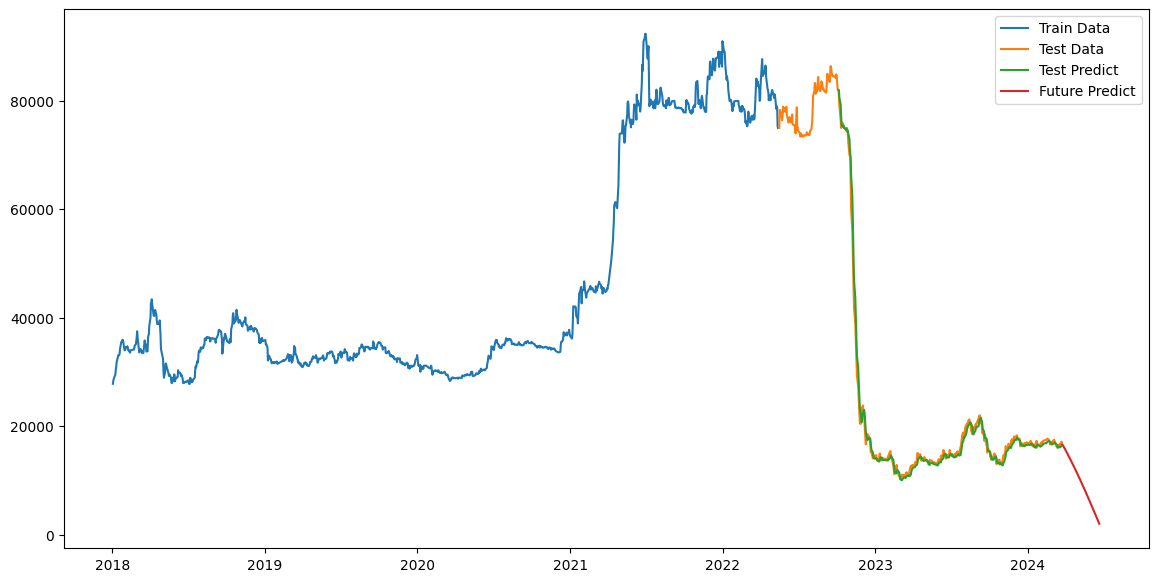

In [16]:
# Calculate future prediction dates
last_test_date = df['Date'].iloc[train_size + test_size - 1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=90)

# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:train_size + test_size], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data
plt.plot(df['Date'][train_size + time_step:train_size + test_size-1], y_pred, label='Test Predict')

# Plot future predictions
plt.plot(future_predict_dates, future_predict, label='Future Predict')


# Display the legend
plt.legend()

# Display the plot
plt.show()